# 2. Characterising companies based on financial metrics - Factor Analysis
## Instructions
Previously, the author performed principle component analysis on the finanical metrics for all the S&P500 companies and found that the first 5 PCs carried most of the variance ratio. Note that a pcincipal component (dimension) from PCA can be considered factor that consist of a space that made up of a set of features. Here, we look at the first 3 PCs/factors and their respective underlying features.

## Packages
You'll need to you install the quanp package (https://quanp.readthedocs.io/en/latest/installation.html) that should install all necessary packages/libraries required to execute the codes in this tutorial. Please create and use virtualenv with python version 3.6 to avoid dependency problem.

### Install Packages

In [19]:
import sys
# !conda install seaborn scikit-learn statsmodels numba pytables
# !conda install -c conda-forge python-igraph leidenalg
# !{sys.executable} -m pip install quanp
!{sys.executable} -m pip install factor_analyzer

### Import Packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import quanp as qp

from IPython.display import display
from matplotlib import rcParams

# setting visualization/logging parameters
pd.set_option('display.max_columns', None)
qp.set_figure_params(dpi=100, color_map = 'viridis_r')
qp.settings.verbosity = 1
qp.logging.print_versions()

### Download data

In [ ]:
# S&P 500 metadata
df_metadata = qp.datasets.get_wiki_sp500_metadata()
# 
# S&P 500 fundamentals
df_fundamental = qp.datasets.download_tickers_fundamental()

### Loading data

In [5]:
# Optional: The data retried in cell above were saved as csv file You may activated this cell to avoid 
# rerunning the downloading cell above.
df_fundamental = pd.read_csv('data/metadata/sp500_metadata_fundamentalAdded.csv', index_col=0)
print(df_fundamental.columns)

Index(['Security', 'SEC filings', 'GICS Sector', 'GICS Sub Industry',
       'Headquarters Location', 'Date first added', 'CIK', 'Founded', 'beta',
       'bookValuePerShare', 'currentRatio', 'divGrowthRate3Year',
       'dividendAmount', 'dividendDate', 'dividendPayAmount',
       'dividendPayDate', 'dividendYield', 'epsChange', 'epsChangePercentTTM',
       'epsChangeYear', 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'high52',
       'interestCoverage', 'low52', 'ltDebtToEquity', 'marketCap',
       'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM',
       'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
       'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
       'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
       'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
       'shortIntToFloat', 'symbol', 'totalDebtToCapital', 'totalDebtToEquity',
       'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg'],
     

In [6]:
ls_fundamental_target = ['beta','bookValuePerShare','currentRatio', 'dividendYield','epsChangePercentTTM','epsChangeYear',
 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'interestCoverage', 
 'ltDebtToEquity', 'marketCap', 'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM', 
 'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
    'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
    'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
    'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
    'shortIntToFloat', 'totalDebtToCapital', 'totalDebtToEquity',
    'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg']

df_fundamental_target = df_fundamental[ls_fundamental_target]

In [7]:
df_fundamental_target.isnull().values.any()

False

# Factor Analysis

Previously, we found that 

In [8]:
# Loading pandas dataframe as anndata 
adata = qp.AnnData(df_fundamental[ls_fundamental_target])

# log(x+1) transformation for all data
qp.pp.log1p(adata)

# Standardization scaling per feature
# qp.pp.scale(adata)

In [9]:
# add a new `.obs` column for all comapnanies called `GICS_Sector`
adata.obs['GICS_Sector'] = df_fundamental['GICS Sector']
adata

AnnData object with n_obs × n_vars = 505 × 37
    obs: 'GICS_Sector'
    uns: 'log1p'

### Principal component analysis (PCA)
Reduce the dimensionality of the data by running PCA, which reveals the main axes of variation and denoises the data.

In [10]:
qp.tl.pca(adata, svd_solver='auto')

We can make a scatter plot using the first 2 principle components' (PCs') coordinates and try to see if these 2 PCs can separate the GICS_Sector well. For instance, it seems that the Information Technology, Financial, and Energy can be separated from low to high PC1.

/Users/leehongkai/anaconda/envs/quanp_py36/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'GICS_Sector' as categorical


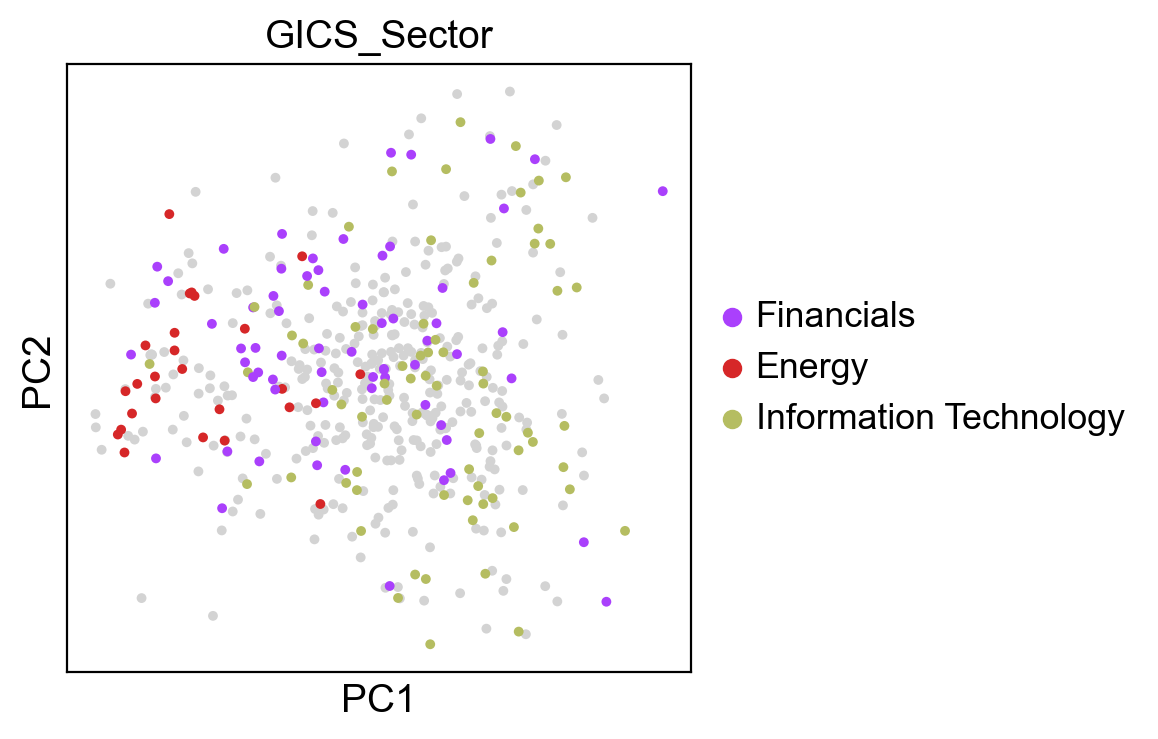

In [11]:
qp.pl.pca(adata, color=['GICS_Sector'], size=50, groups=['Financials', 'Energy', 'Information Technology']);

Let us inspect the contribution of single PCs to the total variance in the data. The 'elbow' point seems to suggest at least up to PC8 will be useful to characterize the companies. 

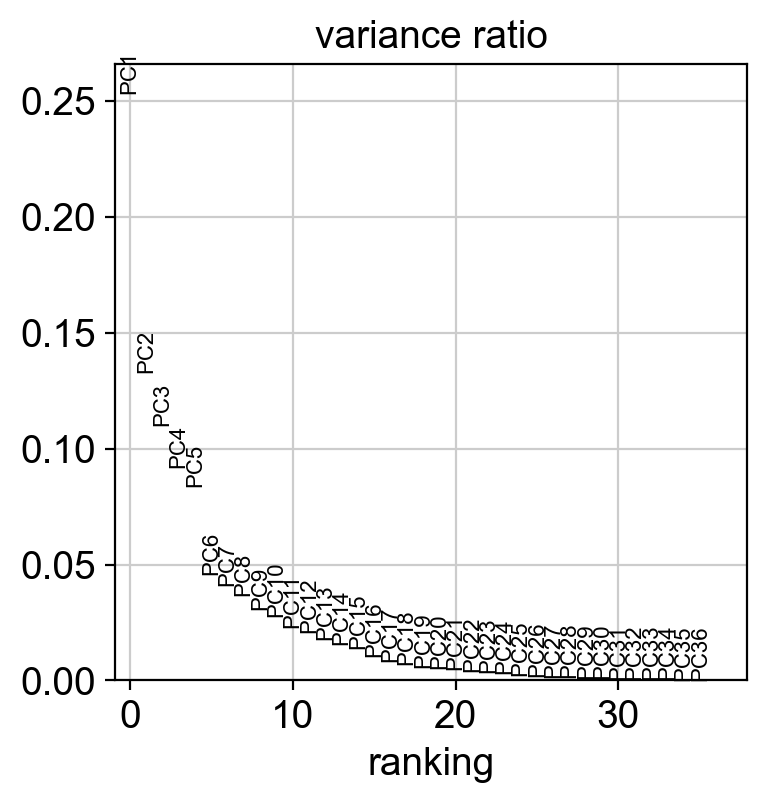

In [12]:
qp.pl.pca_variance_ratio(adata, n_pcs=len(adata.var_names))

In [13]:
df_fundamental_anndata = adata.to_df()

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 10))

feature_minmax = pd.DataFrame(data=df_fundamental_anndata)
feature_minmax[df_fundamental_anndata.columns] = scaler.fit_transform(df_fundamental_anndata[df_fundamental_anndata.columns])

feature_minmax = feature_minmax.loc[:, (feature_minmax != 0).any(axis=0)]

In [15]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6) 

# # TODO: Transform log_samples using the PCA fit above
pca_samples = pca.fit_transform(feature_minmax)


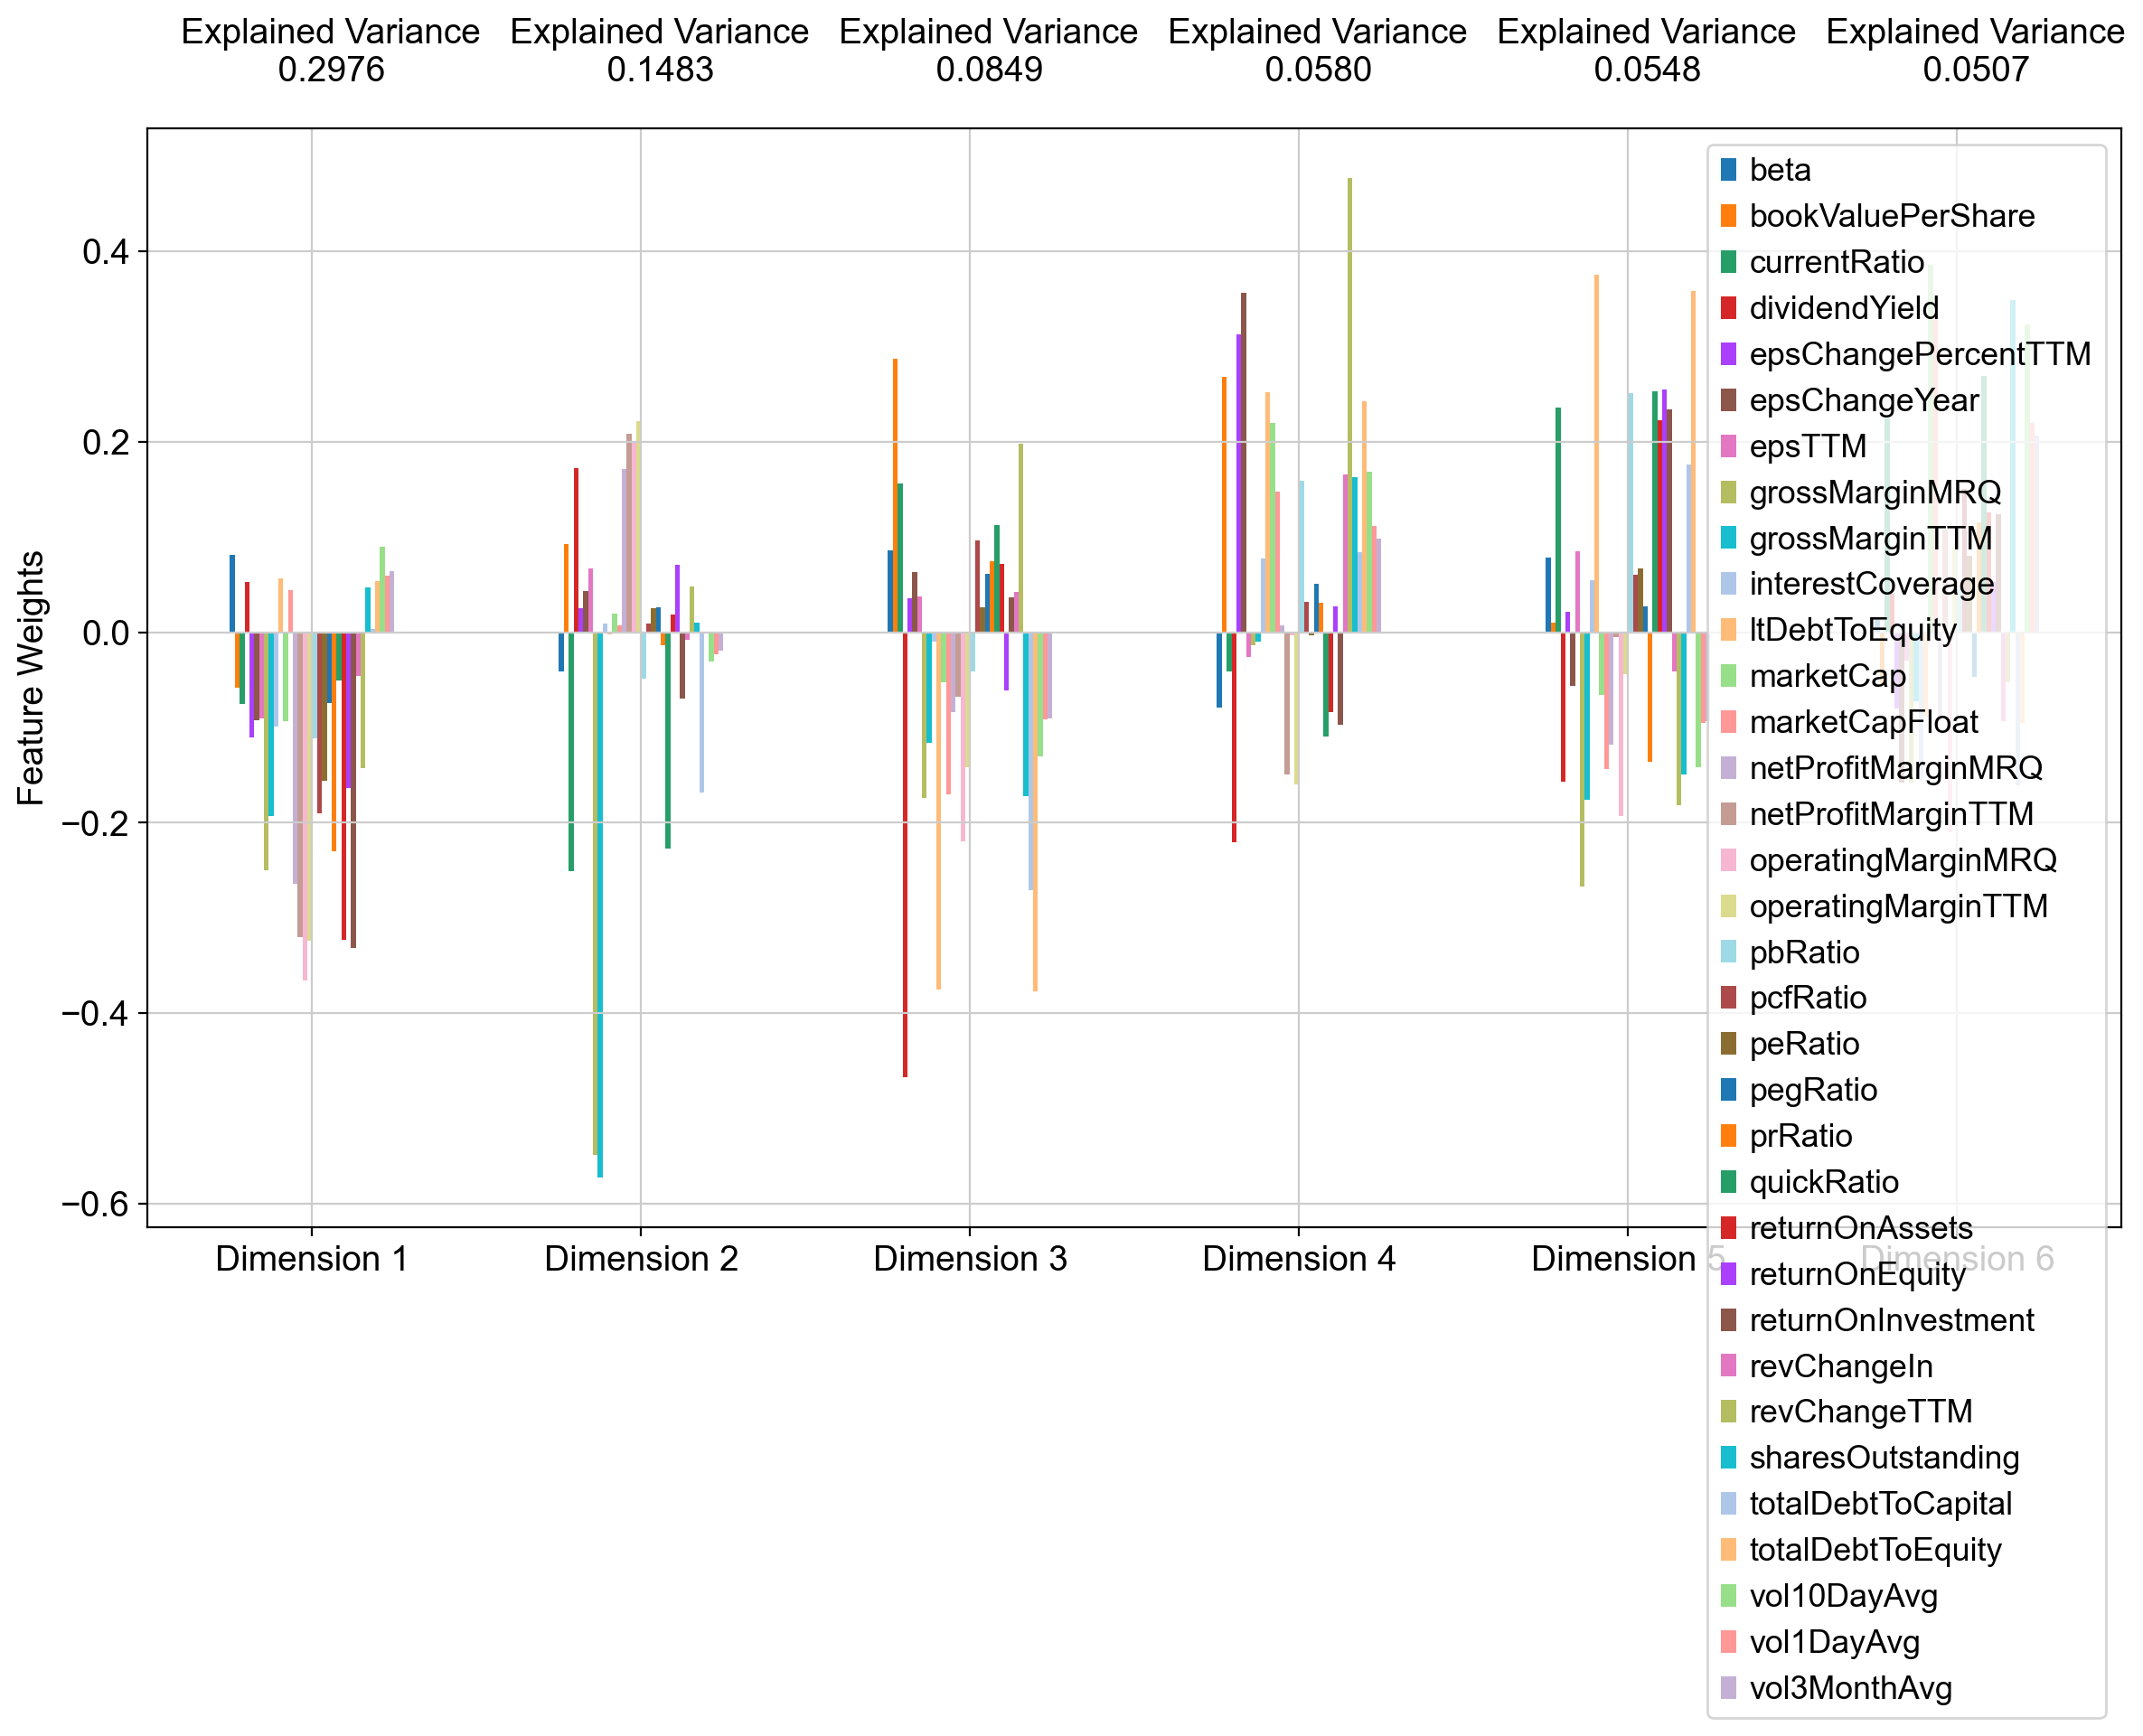

In [16]:
import matplotlib.pyplot as plt

def pca_results(good_data, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

# Generate PCA results plot
pca_results = pca_results(feature_minmax, pca)

In [17]:
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values, index=df_fundamental_anndata.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
MMM,-5.1951,-0.9031,-4.9488,-1.1026,1.9680,1.5845
ABT,-2.8216,-2.2536,-1.3894,1.4851,-1.1438,4.1640
ABBV,-3.2707,-1.8420,-6.4999,3.3128,0.7576,3.4393
ABMD,-9.2182,-3.2056,9.0970,-6.5048,-0.3288,2.3503
ACN,-6.2112,1.7513,4.9434,-0.7149,-3.3125,2.6429
...,...,...,...,...,...,...
YUM,-5.4725,-0.8409,-0.0447,-6.5719,-4.1309,0.5863
ZBRA,-4.5547,-0.9977,2.3204,-2.1087,3.0720,-3.4507
ZBH,6.0431,-6.9744,3.2981,1.6716,0.5460,-0.5890
ZION,7.6976,10.2795,2.6553,-4.4023,-0.7136,0.8758


In [18]:
import factor_analyzer as fa
fa.__version__


AttributeError: module 'factor_analyzer' has no attribute '__version__'

In [61]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

calculate_bartlett_sphericity(feature_minmax)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [62]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation=None)
fa.fit(feature_minmax)
ev, v = fa.get_eigenvalues()

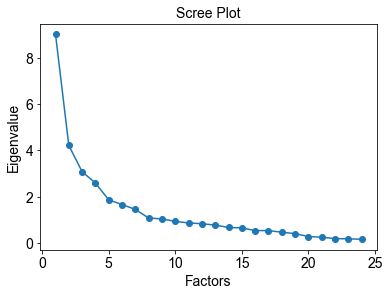

In [66]:
# create scree plot using matplotlib
plt.scatter(range(1, 25), ev[:24])
plt.plot(range(1,25), ev[:24])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [67]:
fa.get_factor_variance()

(array([8.65063262, 3.97127025, 2.58744042]),
 array([0.25443037, 0.11680207, 0.07610119]),
 array([0.25443037, 0.37123244, 0.44733363]))